# **Save this file as studentid1_studentid2_lab2.ipynb**, please check this suffix when you upload your lab, especially when you have multiple copy's in the same folder!
(Your student-id is the number shown on your student card.)

E.g. if you work with 3 people, the notebook should be named:
12301230_3434343_1238938934_lab2.ipynb.

**This will be parsed by a regexp, so please double check your filename.**

Before you turn this problem in, please make sure everything runs correctly. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). Note, that **you are not allowed to use Google Colab**.

**Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your names and email adresses below.**



In [1]:
NAME = "Yijie Zhang"
NAME2 = "Xiaoxiao Wen"
EMAIL = "yijie.zhang@student.uva.nl"
EMAIL2 = "xiaoxiao.wen@student.uva.nl"

# Lab 2: Classification

### Machine Learning 1, November 2018

Notes on implementation:

* You should write your code and answers in this IPython Notebook: http://ipython.org/notebook.html. If you have problems, please contact your teaching assistant.
* Please write your answers right below the questions.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Use the provided test cells to check if your answers are correct
* **Make sure your output and plots are correct before handing in your assignment with Kernel -> Restart & Run All**

* **If possible, all your implementations should be vectorized and rely on loops as little as possible. Therefore for some questions, we give you a maximum number of loops that are necessary for an efficient implementation. This number refers to the loops in this particular function and does not count the ones in functions that are called from the function. You should not go above this number for the maximum number of points.**

$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bm}{\mathbf{m}}$
$\newcommand{\bb}{\mathbf{b}}$
$\newcommand{\bS}{\mathbf{S}}$
$\newcommand{\ba}{\mathbf{a}}$
$\newcommand{\bz}{\mathbf{z}}$
$\newcommand{\bv}{\mathbf{v}}$
$\newcommand{\bq}{\mathbf{q}}$
$\newcommand{\bp}{\mathbf{p}}$
$\newcommand{\bh}{\mathbf{h}}$
$\newcommand{\bI}{\mathbf{I}}$
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bT}{\mathbf{T}}$
$\newcommand{\bPhi}{\mathbf{\Phi}}$
$\newcommand{\bW}{\mathbf{W}}$
$\newcommand{\bV}{\mathbf{V}}$

In [2]:
%pylab inline
plt.rcParams["figure.figsize"] = [9,5]

import time
start = time.time()

Populating the interactive namespace from numpy and matplotlib


In [3]:
# This cell makes sure that you have all the necessary libraries installed

import sys
import platform
from importlib.util import find_spec, module_from_spec

def check_newer_version(version_inst, version_nec):
    version_inst_split = version_inst.split('.')
    version_nec_split = version_nec.split('.')
    for i in range(min(len(version_inst_split), len(version_nec_split))):
        if int(version_nec_split[i]) > int(version_inst_split[i]):
            return False
        elif int(version_nec_split[i]) < int(version_inst_split[i]):
            return True
    return True
        
    
module_list = [('jupyter', '1.0.0'), 
               ('matplotlib', '2.0.2'), 
               ('numpy', '1.13.1'), 
               ('python', '3.6.2'), 
               ('sklearn', '0.19.0'), 
               ('scipy', '0.19.1'), 
               ('nb_conda', '2.2.1')]

packages_correct = True
packages_errors = []

for module_name, version in module_list:
    if module_name == 'scikit-learn':
        module_name = 'sklearn'
    if module_name == 'pyyaml':
        module_name = 'yaml'
    if 'python' in module_name:
        python_version = platform.python_version()
        if not check_newer_version(python_version, version):
            packages_correct = False
            error = f'Update {module_name} to version {version}. Current version is {python_version}.'
            packages_errors.append(error) 
            print(error)
    else:
        spec = find_spec(module_name)
        if spec is None:
            packages_correct = False
            error = f'Install {module_name} with version {version} or newer, it is required for this assignment!'
            packages_errors.append(error) 
            print(error)
        else:
            x =__import__(module_name)
            if hasattr(x, '__version__') and not check_newer_version(x.__version__, version):
                packages_correct = False
                error = f'Update {module_name} to version {version}. Current version is {x.__version__}.'
                packages_errors.append(error) 
                print(error)

try:
    from google.colab import drive
    packages_correct = False
    error = """Please, don't use google colab!
It will make it much more complicated for us to check your homework as it merges all the cells into one."""
    packages_errors.append(error) 
    print(error)
except:
    pass

packages_errors = '\n'.join(packages_errors)

# Part 1. Multiclass logistic regression

Scenario: you have a friend with one big problem: she's completely blind. You decided to help her: she has a special smartphone for blind people, and you are going to develop a mobile phone app that can do _machine vision_ using the mobile camera: converting a picture (from the camera) to the meaning of the image. You decide to start with an app that can read handwritten digits, i.e. convert an image of handwritten digits to text (e.g. it would enable her to read precious handwritten phone numbers).

A key building block for such an app would be a function `predict_digit(x)` that returns the digit class of an image patch $\bx$. Since hand-coding this function is highly non-trivial, you decide to solve this problem using machine learning, such that the internal parameters of this function are automatically learned using machine learning techniques.

The dataset you're going to use for this is the MNIST handwritten digits dataset (`http://yann.lecun.com/exdb/mnist/`). You can download the data with scikit learn, and load it as follows:

In [4]:
from sklearn.datasets import fetch_mldata
import os
# Fetch the data
try:
    mnist = fetch_mldata('MNIST original', data_home='.')
except Exception:
    raise FileNotFoundError('Please download mnist-original.mat from Canvas and put it in %s/mldata' % os.getcwd())
data, target = mnist.data, mnist.target.astype('int')
# Shuffle
indices = np.arange(len(data))
np.random.seed(123)
np.random.shuffle(indices)
data, target = data[indices].astype('float32'), target[indices]

# Normalize the data between 0.0 and 1.0:
data /= 255. 

# Split
x_train, x_valid, x_test = data[:50000], data[50000:60000], data[60000: 70000]
t_train, t_valid, t_test = target[:50000], target[50000:60000], target[60000: 70000]

MNIST consists of small 28 by 28 pixel images of written digits (0-9). We split the dataset into a training, validation and testing arrays. The variables `x_train`, `x_valid` and `x_test` are $N \times M$ matrices, where $N$ is the number of datapoints in the respective set, and $M = 28^2 = 784$ is the dimensionality of the data. The second set of variables `t_train`, `t_valid` and `t_test` contain the corresponding $N$-dimensional vector of integers, containing the true class labels.

Here's a visualisation of the first 8 digits of the trainingset:

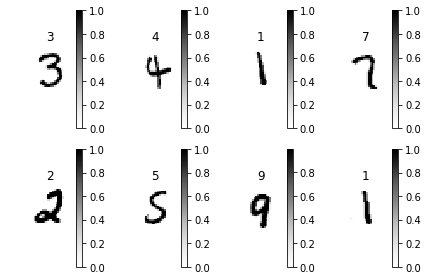

In [5]:
def plot_digits(data, num_cols, targets=None, shape=(28,28)):
    num_digits = data.shape[0]
    num_rows = int(num_digits/num_cols)
    for i in range(num_digits):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(data[i].reshape(shape), interpolation='none', cmap='Greys')
        if targets is not None:
            plt.title(int(targets[i]))
        plt.colorbar()
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
plot_digits(x_train[0:40000:5000], num_cols=4, targets=t_train[0:40000:5000])

In _multiclass_ logistic regression, the conditional probability of class label $j$ given the image $\bx$ for some datapoint is given by:

$ \log p(t = j \;|\; \bx, \bb, \bW) = \log q_j - \log Z$

where $\log q_j = \bw_j^T \bx + b_j$ (the log of the unnormalized probability of the class $j$), and $Z = \sum_k q_k$ is the normalizing factor. $\bw_j$ is the $j$-th column of $\bW$ (a matrix of size $784 \times 10$) corresponding to the class label, $b_j$ is the $j$-th element of $\bb$.

Given an input image, the multiclass logistic regression model first computes the intermediate vector $\log \bq$ (of size $10 \times 1$), using $\log q_j = \bw_j^T \bx + b_j$, containing the unnormalized log-probabilities per class. 

The unnormalized probabilities are then normalized by $Z$ such that $\sum_j p_j = \sum_j \exp(\log p_j) = 1$. This is done by $\log p_j = \log q_j - \log Z$ where $Z = \sum_i \exp(\log q_i)$. This is known as the _softmax_ transformation, and is also used as a last layer of many classifcation neural network models, to ensure that the output of the network is a normalized distribution, regardless of the values of second-to-last layer ($\log \bq$)

**Warning**: when computing $\log Z$, you are likely to encounter numerical problems. Save yourself countless hours of debugging and learn the [log-sum-exp trick](https://www.xarg.org/2016/06/the-log-sum-exp-trick-in-machine-learning/ "Title").

The network's output $\log \bp$ of size $10 \times 1$ then contains the conditional log-probabilities $\log p(t = j \;|\; \bx, \bb, \bW)$ for each digit class $j$. In summary, the computations are done in this order:

$\bx \rightarrow \log \bq \rightarrow Z \rightarrow \log \bp$

Given some dataset with $N$ independent, identically distributed datapoints, the log-likelihood is given by:

$ \mathcal{L}(\bb, \bW) = \sum_{n=1}^N \mathcal{L}^{(n)}$

where we use $\mathcal{L}^{(n)}$ to denote the partial log-likelihood evaluated over a single datapoint. It is important to see that the log-probability of the class label $t^{(n)}$ given the image, is given by the $t^{(n)}$-th element of the network's output $\log \bp$, denoted by $\log p_{t^{(n)}}$:

$\mathcal{L}^{(n)} = \log p(t = t^{(n)} \;|\; \bx = \bx^{(n)}, \bb, \bW) = \log p_{t^{(n)}} = \log q_{t^{(n)}} - \log Z^{(n)}$

where $\bx^{(n)}$ and $t^{(n)}$ are the input (image) and class label (integer) of the $n$-th datapoint, and $Z^{(n)}$ is the normalizing constant for the distribution over $t^{(n)}$.


## 1.1 Gradient-based stochastic optimization
### 1.1.1 Derive gradient equations (20 points)

Derive the equations for computing the (first) partial derivatives of the log-likelihood w.r.t. all the parameters, evaluated at a _single_ datapoint $n$.

You should start deriving the equations for $\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$ for each $j$. For clarity, we'll use the shorthand $\delta^q_j = \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$.

For $j = t^{(n)}$:
$$
\delta^q_j
= \frac{\partial \log q_{t^{(n)}}}{\partial \log q_j}
-
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
= 1
-
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
$$

For $j \neq t^{(n)}$:
$$
\delta^q_j
= \frac{\partial \log q_{t^{(n)}}}{\partial \log q_j}
-
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
=0 - \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j}
$$

Complete the above derivations for $\delta^q_j$ by furtherly developing $\frac{\partial \log Z}{\partial Z}$ and $\frac{\partial Z}{\partial \log q_j}$. Both are quite simple. For these it doesn't matter whether $j = t^{(n)}$ or not.



For $j = t^{(n)}$:
\begin{align}
\delta^q_j
&= 1 - \frac{q_{j}}{Z}
\end{align}
For $j \neq t^{(n)}$:
\begin{align}
\delta^q_j
&= 0 - \frac{q_{j}}{Z}
\end{align}

Given your equations for computing the gradients $\delta^q_j$ it should be quite straightforward to derive the equations for the gradients of the parameters of the model, $\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}}$ and $\frac{\partial \mathcal{L}^{(n)}}{\partial b_j}$. The gradients for the biases $\bb$ are given by:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial b_j}
= \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial b_j}
= \delta^q_j
\cdot 1
= \delta^q_j
$

The equation above gives the derivative of $\mathcal{L}^{(n)}$ w.r.t. a single element of $\bb$, so the vector $\nabla_\bb \mathcal{L}^{(n)}$ with all derivatives of $\mathcal{L}^{(n)}$ w.r.t. the bias parameters $\bb$ is: 

$
\nabla_\bb \mathcal{L}^{(n)} = \mathbf{\delta}^q
$

where $\mathbf{\delta}^q$ denotes the vector of size $10 \times 1$ with elements $\mathbf{\delta}_j^q$.

The (not fully developed) equation for computing the derivative of $\mathcal{L}^{(n)}$ w.r.t. a single element $W_{ij}$ of $\bW$ is:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} =
\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial W_{ij}}
= \mathbf{\delta}_j^q
\frac{\partial \log q_j}{\partial W_{ij}}
$

What is $\frac{\partial \log q_j}{\partial W_{ij}}$? Complete the equation above.

If you want, you can give the resulting equation in vector format ($\nabla_{\bw_j} \mathcal{L}^{(n)} = ...$), like we did for $\nabla_\bb \mathcal{L}^{(n)}$.

Note: according to the convention defined in this course, $\mathbf{\delta}^q$ is of size $1 \times 10$, which is used further in this lab.

$$
\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} =
\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial W_{ij}}
= \mathbf{\delta}_j^q
\frac{\partial \log q_j}{\partial W_{ij}}
= \mathbf{\delta}_j^q
\frac{\partial (\bw_j^T \bx + b_j)}{\partial W_{ij}}
= \mathbf{\delta}_j^q
\frac{\partial (\sum_{i=1}^{M} (W_{ij} x_{i}) + b_j)}{\partial W_{ij}}
= \mathbf{\delta}_j^q
x_{i}
$$

$$
\nabla_{\bw_{j}} \mathcal{L}^{(n)} = \mathbf{\delta}_j^q {\bx^{(n)}}^{T}
$$

### 1.1.2 Implement gradient computations (15 points)

Implement the gradient calculations you derived in the previous question. Write a function `logreg_gradient(x, t, w, b)` that returns the gradients $\nabla_{\bw_j} \mathcal{L}^{(n)}$ (for each $j$) and $\nabla_{\bb} \mathcal{L}^{(n)}$, i.e. the first partial derivatives of the log-likelihood w.r.t. the parameters $\bW$ and $\bb$, evaluated at a single datapoint (`x`, `t`).
The computation will contain roughly the following intermediate variables:

$
\log \bq \rightarrow Z \rightarrow \log \bp\,,\, \mathbf{\delta}^q
$

followed by computation of the gradient vectors $\nabla_{\bw_j} \mathcal{L}^{(n)}$ (contained in a $784 \times 10$ matrix) and $\nabla_{\bb} \mathcal{L}^{(n)}$ (a $10 \times 1$ vector).

For maximum points, ensure the function is numerically stable.


In [6]:
# 1.1.2 Compute gradient of log p(t|x;w,b) wrt w and b
def logreg_gradient(x, t, w, b):    
    # Adjust the shapes to match the conventions of the analytical derivations.
    x = x.squeeze()
    x = x[:, np.newaxis]
    b = b[:, np.newaxis]
    
    logq = w.T.dot(x) + b
    q = np.exp(logq)
    log_sum_exp_offset = np.max(logq, axis=0)
    Z = np.sum(q)
    logZ = log_sum_exp_offset + np.log(np.sum(np.exp(logq - log_sum_exp_offset)))
    logp = logq - logZ
    delta_q = -q.T / Z
    delta_q[:, t] += 1
    dL_dw = delta_q.T.dot(x.T)
    dL_db = delta_q
    
    # here the statement contains logp[:,t] where logp is meant tas a matrix of shape 1x10
    # Transpose the results to match the numpy convention.
    logp = np.transpose(logp)
    dL_dw = np.transpose(dL_dw)
    dL_db = np.transpose(dL_db)
    return logp[:,t].squeeze(), dL_dw, dL_db.squeeze()


In [7]:
# Hidden tests for efficiency

In [8]:
np.random.seed(123)
# scalar, 10 X 768  matrix, 10 X 1 vector
w = np.random.normal(size=(28*28,10), scale=0.001)
# w = np.zeros((784,10))
b = np.zeros((10,))

# test gradients, train on 1 sample
logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)

print("Test gradient on one point")
print("Log Likelihood:\t", logpt)
print("\nGrad_W_ij\t",grad_w.shape,"matrix")
print("Grad_W_ij[0,152:158]=\t", grad_w[152:158,0])
print("\nGrad_B_i shape\t",grad_b.shape,"vector")
print("Grad_B_i=\t", grad_b.T)
print("i in {0,...,9}; j in M")

assert logpt.shape == (), logpt.shape
assert grad_w.shape == (784, 10), grad_w.shape
assert grad_b.shape == (10,), grad_b.shape




Test gradient on one point
Log Likelihood:	 -2.2959726720744777

Grad_W_ij	 (784, 10) matrix
Grad_W_ij[0,152:158]=	 [-0.04518971 -0.06758809 -0.07819784 -0.09077237 -0.07584012 -0.06365855]

Grad_B_i shape	 (10,) vector
Grad_B_i=	 [-0.10020327 -0.09977827 -0.1003198   0.89933657 -0.10037941 -0.10072863
 -0.09982729 -0.09928672 -0.09949324 -0.09931994]
i in {0,...,9}; j in M


In [9]:
# It's always good to check your gradient implementations with finite difference checking:
# Scipy provides the check_grad function, which requires flat input variables.
# So we write two helper functions that provide the gradient and output with 'flat' weights:
from scipy.optimize import check_grad

np.random.seed(123)
# scalar, 10 X 768  matrix, 10 X 1 vector
w = np.random.normal(size=(28*28,10), scale=0.001)
# w = np.zeros((784,10))
b = np.zeros((10,))

def func(w):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w.reshape(784,10), b)
    return logpt
def grad(w):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w.reshape(784,10), b)
    return grad_w.flatten()
finite_diff_error = check_grad(func, grad, w.flatten())
print('Finite difference error grad_w:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for w seems off'

def func(b):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)
    return logpt
def grad(b):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)
    return grad_b.flatten()
finite_diff_error = check_grad(func, grad, b)
print('Finite difference error grad_b:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for b seems off'



Finite difference error grad_w: 6.36129469829e-07
Finite difference error grad_b: 5.23511749617e-08


In [10]:
# DO NOT REMOVE THIS CELL!
# It contains hidden tests



### 1.1.3 Stochastic gradient descent (15 points)

Write a function `sgd_iter(x_train, t_train, w, b)` that performs one iteration of stochastic gradient descent (SGD), and returns the new weights. It should go through the trainingset once in randomized order, call `logreg_gradient(x, t, w, b)` for each datapoint to get the gradients, and update the parameters **using a small learning rate of `1e-6`**. Note that in this case we're maximizing the likelihood function, so we should actually performing gradient ___ascent___... For more information about SGD, see Bishop 5.2.4 or an online source (i.e. https://en.wikipedia.org/wiki/Stochastic_gradient_descent)

In [11]:
# A learning rate of 1e-4 is used instead according to the correction mentioned on Piazza.
def sgd_iter(x_train, t_train, W, b, lr=1e-4):    
    t_idxs = np.arange(x_train.shape[0])
    np.random.shuffle(t_idxs)
    logp_train = 0.0    
    for t_idx in t_idxs:
        logp, dL_dw, dL_db = logreg_gradient(x_train[t_idx, :], t_train[t_idx], W, b)        
        W += lr * dL_dw      
        b += lr * dL_db         
        logp_train += logp
    logp_train /= len(t_idxs)    
    return logp_train, W, b

In [12]:
# Hidden tests for efficiency

In [13]:
# Sanity check:
np.random.seed(1243)
w = np.zeros((28*28, 10))
b = np.zeros(10)
    
logp_train, W, b = sgd_iter(x_train[:5], t_train[:5], w, b)




## 1.2. Train

### 1.2.1 Train (12 points)
Perform SGD on the training set. Plot (in one graph) the conditional log-probability of the training set and validation set after each iteration. (6 points)

Instead of running SGD for a fixed number of steps, run it until convergence. Think of a reasonable criterion for determining convergence. As a reference: choose a criterion such that the algorithm terminates in less than 15 iterations over the training set. (2 points)

Make sure your implementation (in particular, the output of the conditional log-probability of the training set and validation set) is independent of the size of the dataset. (2 points)

Number of iterations: 10


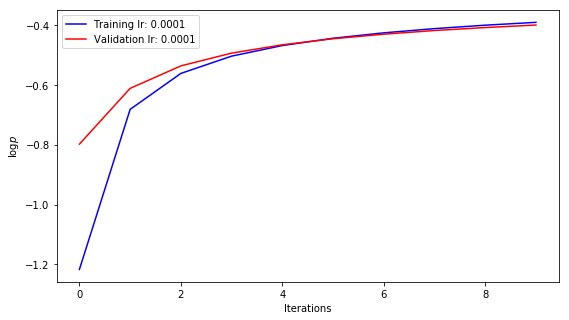

In [14]:
def test_sgd(x_train, t_train, x_valid, t_valid, w, b):
    epsilon = 1e-2
    difference = 1e5    
    logp_train_data = []
    logp_valid_data = []
    iters = 0
    while difference > epsilon:
        logp_train, w, b = sgd_iter(x_train, t_train, w, b)        
        logp_train_data.append(logp_train)
        
        logq = (matmul(x_valid,w)+ b.reshape(1,10))
        q = np.exp(logq)
        Z = np.sum(q,axis=1).reshape(10000,1)
        logp=(logq-np.log(Z))
        logp_targets = logp[np.arange(logp.shape[0]),t_valid]
        logp_valid = np.mean(logp_targets)
        logp_valid_data.append(logp_valid)
        
        iters += 1
        if len(logp_train_data) < 2:
            continue
        else:
            difference = np.abs(logp_train_data[-1] - logp_train_data[-2])                    
    print('Number of iterations: {}'.format(iters))    
    plt.figure(figsize=(9,5))
    ax = plt.subplot(111)
    plt.plot(np.arange(len(logp_train_data)), logp_train_data, color='blue', label='Training lr: 0.0001')
    plt.plot(np.arange(len(logp_valid_data)), logp_valid_data, color='red', label='Validation lr: 0.0001')
    plt.xlabel('Iterations')
    plt.ylabel(r'$\log p$')
    plt.legend()
    plt.show()
    return w, b
        
np.random.seed(1243)
w = np.zeros((28*28, 10))
b = np.zeros(10)
w, b = test_sgd(x_train, t_train, x_valid, t_valid, w, b)

In [15]:
# Hidden tests for efficiency

### 1.2.2 Visualize weights (10 points)
Visualize the resulting parameters $\bW$ after a few iterations through the training set, by treating each column of $\bW$ as an image. If you want, you can use or edit the `plot_digits(...)` above.


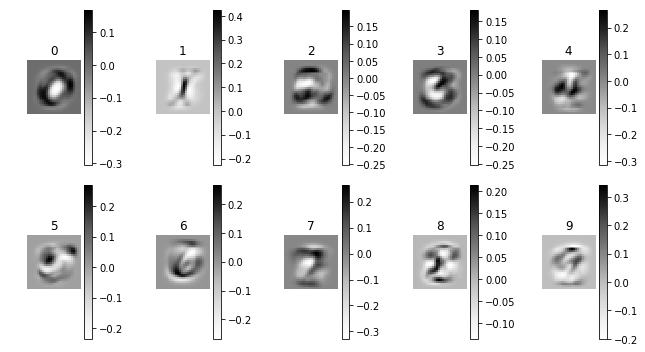

In [16]:
plt.figure(figsize=(9,5))
plot_digits(data=w.T, num_cols=5, targets=np.arange(10))

**Describe in less than 100 words why these weights minimize the loss**

To minimize the loss is the same as to maximize log likelihood, which is equivalent as to find $\bw_j$ that maximizes $\bw_j^T \bx$. Since in $\bx$, the blacker a pixel, the higher its value $x_{i}$, in order to maximize $\bw_j^T \bx$, the corresponding weights $W_{ij}$ for blacker pixels will increase much more significantly than the weights $W_{ij}$ for other whiter pixels $x_{i}$ through training. To conclude, the $\bw_j$ that minimize the loss learns the patterns of $j$. 

As shown in the visualizations, after 10 iterations, the learned weights $\bW$ are already resembling the patterns of the digits 0-9 respectively. 

### 1.2.3. Visualize the 8 hardest and 8 easiest digits (10 points)
Visualize the 8 digits in the validation set with the highest probability of the true class label under the model.
Also plot the 8 digits that were assigned the lowest probability.


8 digits in the validation set with the highest probability of the true class label:


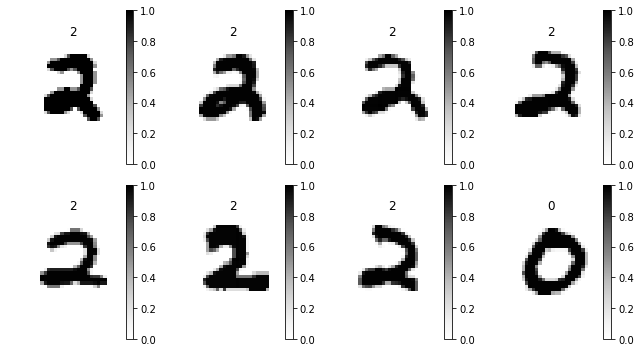

8 digits in the validation set with the lowest probability of the true class label:


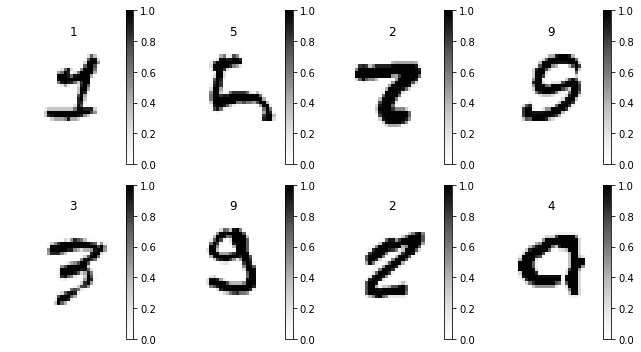

In [17]:
def visualize_good_bad_examples(x_valid, w, b):
    logp_valid_data = []
    for i_valid in np.arange(x_valid.shape[0]):
        logp_valid, _, _ = logreg_gradient(x_valid[i_valid, :], t_valid[i_valid], w, b)
        logp_valid_data.append((i_valid, logp_valid))
    logp_valid_data = sorted(logp_valid_data, key=lambda x: x[1], reverse=True)    
    good_examples = np.empty([8, x_valid.shape[1]])
    good_targets = np.empty([8])
    for i, logp_pair in enumerate(logp_valid_data[0:8]):
        good_examples[i, :] = x_valid[logp_pair[0]]
        good_targets[i] = t_valid[logp_pair[0]]
    bad_examples = np.empty([8, x_valid.shape[1]])
    bad_targets = np.empty([8])
    for i, logp_pair in enumerate(logp_valid_data[-8:]):
        bad_examples[i, :] = x_valid[logp_pair[0]]
        bad_targets[i] = t_valid[logp_pair[0]]        
    print('8 digits in the validation set with the highest probability of the true class label:')
    plt.figure(figsize=(9,5))
    plot_digits(data=good_examples, num_cols=4, targets=good_targets)
    print('8 digits in the validation set with the lowest probability of the true class label:')
    plt.figure(figsize=(9,5))
    plot_digits(data=bad_examples, num_cols=4, targets=bad_targets)
        
visualize_good_bad_examples(x_valid, w, b)

Ask yourself if these results make sense. Explain in no more then two sentences what it means that a digit is hard to classify.

In human perspective, I can't say the 8 digits with highest probability are the easiest to recognize, but the ones with lowest probability are indeed confusing, for example, the "4" in last row actually confuses a human being to a "0".

If a digit is hard to classify, it means that the digit contains the shape, edge or patterns that is typical in other digits but relatively rare in its own class, take "9" in the last row as an example, the "hook" shape slightly heading up in the end is typical in a "5" or "3", while in a "9" there is less curve.

# Part 2. Multilayer perceptron


You discover that the predictions by the logistic regression classifier are not good enough for your application: the model is too simple. You want to increase the accuracy of your predictions by using a better model. For this purpose, you're going to use a multilayer perceptron (MLP), a simple kind of neural network. The perceptron will have a single hidden layer $\bh$ with $L$ elements. The parameters of the model are $\bV$ (connections between input $\bx$ and hidden layer $\bh$), $\ba$ (the biases/intercepts of $\bh$), $\bW$ (connections between $\bh$ and $\log q$) and $\bb$ (the biases/intercepts of $\log q$).

The conditional probability of the class label $j$ is given by:

$\log p(t = j \;|\; \bx, \bb, \bW) = \log q_j - \log Z$

where $q_j$ are again the unnormalized probabilities per class, and $Z = \sum_j q_j$ is again the probability normalizing factor. Each $q_j$ is computed using:

$\log q_j = \bw_j^T \bh + b_j$

where $\bh$ is a $L \times 1$ vector with the hidden layer activations (of a hidden layer with size $L$), and $\bw_j$ is the $j$-th column of $\bW$ (a $L \times 10$ matrix). Each element of the hidden layer is computed from the input vector $\bx$ using:

$h_j = \sigma(\bv_j^T \bx + a_j)$

where $\bv_j$ is the $j$-th column of $\bV$ (a $784 \times L$ matrix), $a_j$ is the $j$-th element of $\ba$, and $\sigma(.)$ is the so-called sigmoid activation function, defined by:

$\sigma(x) = \frac{1}{1 + \exp(-x)}$

Note that this model is almost equal to the multiclass logistic regression model, but with an extra 'hidden layer' $\bh$. The activations of this hidden layer can be viewed as features computed from the input, where the feature transformation ($\bV$ and $\ba$) is learned.

## 2.1 Derive gradient equations (20 points)

State (shortly) why $\nabla_{\bb} \mathcal{L}^{(n)}$ is equal to the earlier (multiclass logistic regression) case, and why $\nabla_{\bw_j} \mathcal{L}^{(n)}$ is almost equal to the earlier case.

Like in multiclass logistic regression, you should use intermediate variables $\mathbf{\delta}_j^q$. In addition, you should use intermediate variables $\mathbf{\delta}_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial h_j}$.

Given an input image, roughly the following intermediate variables should be computed:

$
\log \bq \rightarrow Z \rightarrow \log \bp \rightarrow \mathbf{\delta}^q \rightarrow \mathbf{\delta}^h
$

where $\mathbf{\delta}_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial \bh_j}$.

Give the equations for computing $\mathbf{\delta}^h$, and for computing the derivatives of $\mathcal{L}^{(n)}$ w.r.t. $\bW$, $\bb$, $\bV$ and $\ba$. 

You can use the convenient fact that $\frac{\partial}{\partial x} \sigma(x) = \sigma(x) (1 - \sigma(x))$.

Similar to the multiclass logistic regression, we can define that $\mathcal{L}^{(n)} = \log p(t = t^{(n)} \;|\; \bx = \bx^{(n)}, \bb, \bW) = \log p_{t^{(n)}} = \log q_{t^{(n)}} - \log Z^{(n)}$.

Then we have
$$
\nabla_{\bb_{j}} \mathcal{L}^{(n)} 
%= \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_{j}}\frac{\partial \log q_j}{\partial b_j} 
%= \mathbf{\delta}_j^q \cdot 1
= \mathbf{\delta}_j^q 
$$
which is the same as the case for multiclass logistic regression because both $\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_{j}}$ and $\frac{\partial \log q_j}{\partial b_j}$ remain the same. Hence, $\nabla_{\bb} \mathcal{L}^{(n)} = \mathbf{\delta}^{q}$.

We can also derive that
$$
\nabla_{\bw_j} \mathcal{L}^{(n)}
= \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_{j}}\frac{\partial \log q_j}{\partial \bw_j} 
= \mathbf{\delta}_j^q \bh^{T}
$$
which is similar to the case for multiclass logistic regression, but we have $\bh^{T}$ instead of $\bx^{T}$ due to the hidden layer. Consequently, we can derive that $\nabla_{\bW} \mathcal{L}^{(n)} = {\mathbf{\delta}^q}^{T}\bh^{T}$.

Then let us compute $\mathbf{\delta}_j^h$ where we have 

$$
\mathbf{\delta}_j^h 
= \frac{\partial \mathcal{L}^{(n)}}{\partial \bh_j} 
= \sum_{k = 1}^{10} \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_k} 
\frac{\partial \log q_k}{\partial h_j}
= \sum_{k = 1}^{10} \mathbf{\delta}_k^q W_{jk}
$$
for which $k \in [1, 10]$ and $j \in [1, L]$.

So we know $\mathbf{\delta}^h = \mathbf{\delta}^q\bW^{T} \in \mathbb{R}^{1\times L}$.


For $\nabla_{\bv_j} \mathcal{L}^{(n)}$, we can derive that
$$
\nabla_{\bv_j} \mathcal{L}^{(n)}
= \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_k} 
\frac{\partial \log q_k}{\partial h_j} 
\frac{\partial h_j}{\partial \bv_j}
= \mathbf{\delta}_j^h \frac{\partial \sigma(\bv_j^T \bx + a_j)}{\partial \bv_j^T \bx + a_j}
\frac{\partial \bv_j^T \bx + a_j}{\partial \bv_j}
= \mathbf{\delta}_j^h \sigma(\bv_j^T \bx + a_j) (1 \sum- \sigma(\bv_j^T \bx + a_j)) \bx^T
= \mathbf{\delta}_j^h h_j (1 - h_j) \bx^T
$$

So we can conclude that $\nabla_{\bV} \mathcal{L}^{(n)} = \mathrm{diag}({\mathbf{\delta}^h}^{T})  \mathrm{diag}(\bh)  (\mathbf{1} - \bh)\bx^{T}$ where $\mathbf{1} \in \mathbb{R}^{L}$ and $\mathrm{diag}(\ba)$ diagonalize vector $\ba$ by making a diagonal matrix with elements from $\ba$ as the respective diagonal elements.

Finally for $\nabla_{a_j} \mathcal{L}^{(n)}$, similar to $\nabla_{\bv_j} \mathcal{L}^{(n)}$ we can derive that
$$
\nabla_{a_j} \mathcal{L}^{(n)}
= \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_k} 
\frac{\partial \log q_k}{\partial h_j} 
\frac{\partial h_j}{\partial a_j}
= \mathbf{\delta}_j^h \frac{\partial \sigma(\bv_j^T \bx + a_j)}{\partial \bv_j^T \bx + a_j}
\frac{\partial \bv_j^T \bx + a_j}{\partial a_j}
= \mathbf{\delta}_j^h \sigma(\bv_j^T \bx + a_j) (1 - \sigma(\bv_j^T \bx + a_j)) \cdot 1
= \mathbf{\delta}_j^h h_j (1 - h_j) 
$$

Hence, we have $\nabla_{\ba} \mathcal{L}^{(n)} = (\mathrm{diag}({\mathbf{\delta}^h}^{T})  \mathrm{diag}(\bh)  (\mathbf{1} - \bh))^T$.

To summarize, the gradients of $\mathcal{L}^{(n)}$ w.r.t. $\bW$, $\bb$, $\bV$ and $\ba$ are correspondingly
$$\nabla_{\bW} \mathcal{L}^{(n)} = {\mathbf{\delta}^q}^{T}\bh^{T}$$
$$\nabla_{\bb} \mathcal{L}^{(n)} = \mathbf{\delta}^{q}$$
$$\nabla_{\bV} \mathcal{L}^{(n)} = \mathrm{diag}({\mathbf{\delta}^h}^{T})  \mathrm{diag}(\bh) (\mathbf{1} - \bh)\bx^{T}$$
and
$$\nabla_{\ba} \mathcal{L}^{(n)} = (\mathrm{diag}({\mathbf{\delta}^h}^{T}) \mathrm{diag}(\bh) (\mathbf{1} - \bh))^T$$
where $$\mathbf{\delta}^h = \mathbf{\delta}^q\bW^{T}$$


## 2.2 MAP optimization (10 points)

You derived equations for finding the _maximum likelihood_ solution of the parameters. Explain, in a few sentences, how you could extend this approach so that it optimizes towards a _maximum a posteriori_ (MAP) solution of the parameters, with a Gaussian prior on the parameters. 

Having a Gaussian prior on the parameters ($\mathbf{0}$ mean and $\frac{1}{\alpha} \mathbf{I}$ covariance) is equivalent to adding a L2-norm regularizer on the parameters to the log-likelihood. So the log-posteriori is then the log-likelihood in addition with the term $-\frac{\alpha}{2}\bw_j^T\bw_j$. So the partial log-posteriori evaluated at a single datapoint of the class label $t^{(n)}$ is
$$
\mathcal{L}^{(n)} = \log q_{t^{(n)}} - \log Z^{(n)} - \frac{\alpha}{2}\bw_{t^{(n)}}^T\bw_{t^{(n)}}
$$

## 2.3. Implement and train a MLP (15 points)

Implement an MLP model with a single hidden layer of **20 neurons**. 
Train the model for **10 epochs**.
Test your implementation for learning rates of 1e-2, 1e-3 and 1e-4 and plot (in one graph) the conditional log-probability of the trainingset and validation set. 

For the best model plot the weights of the first layer for in epoch 0,4 and 9. 


- 10 points: Working MLP that learns with plots
- +5 points: Fast, numerically stable, vectorized implementation

In [18]:
# Write all helper functions here
# YOUR CODE HERE
import copy 
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

#Compute gradient of log p(t|x;w,b) wrt w, b, v and a
def logreg_gradient_mlp(x, t, w, b, v, a):    
    # Adjust the shapes to match the conventions of the analytical derivations.
    x = x.squeeze()
    x = x[:, np.newaxis]
    b = b[:, np.newaxis]
    a = a[:, np.newaxis]
    
    h = sigmoid(v.T.dot(x) + a)
    logq = w.T.dot(h) + b
    q = np.exp(logq)
    log_sum_exp_offset = np.max(logq, axis=0)
    Z = np.sum(q)
    logZ = log_sum_exp_offset + np.log(np.sum(np.exp(logq - log_sum_exp_offset)))
    logp = logq - logZ
    delta_q = -q.T / Z
    delta_q[:, t] += 1
    delta_h = delta_q.dot(w.T)
    
    dL_dw = delta_q.T.dot(h.T)  
    dL_db = delta_q
    tmp_da = np.diag(delta_h.squeeze()).dot(np.diag(h.squeeze())).dot(1 - h)
    dL_dv = tmp_da.dot(x.T)
    dL_da = tmp_da.T
    
    # here the statement contains logp[:,t] where logp is meant tas a matrix of shape 1x10
    # Transpose the results to match the numpy convention.
    logp = np.transpose(logp)
    dL_dw = np.transpose(dL_dw)
    dL_db = np.transpose(dL_db)
    dL_dv = np.transpose(dL_dv)
    dL_da = np.transpose(dL_da)
    return logp[:,t].squeeze(), dL_dw, dL_db.squeeze(), dL_dv, dL_da.squeeze()

def sgd_iter_mlp(x_train, t_train, W, b, V, a, lr=1e-4):
    
    t_idxs = np.arange(x_train.shape[0])
    np.random.shuffle(t_idxs)
    logp_train = 0.0    
    for t_idx in t_idxs:
        logp, dL_dw, dL_db, dL_dv, dL_da = logreg_gradient_mlp(x_train[t_idx, :], t_train[t_idx], W, b, V, a)                
        W += lr * dL_dw        
        b += lr * dL_db          
        V += lr * dL_dv
        a += lr * dL_da
        logp_train += logp
    logp_train /= len(t_idxs)    
    return logp_train, W, b, V, a

def test_sgd_mlp(x_train, t_train, x_valid, t_valid, w, b, v, a, epsilon=1e-2, lr=1e-4):
    epochs = 10
    logp_train_data = []
    logp_valid_data = []

    v0 = 0
    v4 = 0
    v9 = 0
    iters = 0
    for i in np.arange(epochs):
        
        logp_train, w, b, v, a = sgd_iter_mlp(x_train, t_train, w, b, v, a, lr=lr)         
        logp_train_data.append(logp_train)
        logp_valid = 0
        
        h = sigmoid(matmul(x_valid,v)+ a.reshape(1,20))
        logq = matmul(h,w)+ b.reshape(1,10)
        q = np.exp(logq)
        Z = np.sum(q,axis=1).reshape(10000,1)
        logp=(logq-np.log(Z))
        logp_targets = logp[np.arange(logp.shape[0]),t_valid]
        logp_valid = np.mean(logp_targets)
        logp_valid_data.append(logp_valid)
                
        if lr == 1e-2:
            if i == 0:
                v0 = copy.deepcopy(v)
            if i == 4:
                v4 = copy.deepcopy(v)
            if i == 9:
                v9 = copy.deepcopy(v)
        iters += 1
        
    print('Number of iterations: {}'.format(iters))
    return v, logp_train_data, logp_valid_data, [v0,v4,v9]

L = 20
np.random.seed(123)
w = np.random.normal(size=(L, 10), scale=0.001)
b = np.zeros((10,))
v = np.random.normal(size=(28*28, L), scale=0.001)
a = np.zeros((L,))

# gradient check
def func_mlp(w):
#     logpt, grad_w, grad_b, grad_v, grad_a = logreg_gradient_mlp(x_train[0:1,:], t_train[0:1], w.reshape(L,10), b, v.reshape(784,L), a)
    logpt, grad_w, grad_b, grad_v, grad_a = logreg_gradient_mlp(x_train[0:1,:], t_train[0:1], w.reshape(L,10), b, v, a)
    return logpt
def grad_mlp(w):
    logpt, grad_w, grad_b, grad_v, grad_a = logreg_gradient_mlp(x_train[0:1,:], t_train[0:1], w.reshape(L,10), b, v, a)
    return grad_w.flatten()
finite_diff_error = check_grad(func_mlp, grad_mlp, w.flatten())
print('Finite difference error grad_w:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for w seems off'

def func_mlp(b):
    logpt, grad_w, grad_b, grad_v, grad_a = logreg_gradient_mlp(x_train[0:1,:], t_train[0:1], w, b, v, a)
    return logpt
def grad_mlp(b):
    logpt, grad_w, grad_b, grad_v, grad_a = logreg_gradient_mlp(x_train[0:1,:], t_train[0:1], w, b, v, a)
    return grad_b.flatten()
finite_diff_error = check_grad(func_mlp, grad_mlp, b)
print('Finite difference error grad_b:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for b seems off'

def func_mlp(v):
    logpt, grad_w, grad_b, grad_v, grad_a = logreg_gradient_mlp(x_train[0:1,:], t_train[0:1], w, b, v.reshape(784,L), a)
    return logpt
def grad_mlp(v):
    logpt, grad_w, grad_b, grad_v, grad_a = logreg_gradient_mlp(x_train[0:1,:], t_train[0:1], w, b, v.reshape(784,L), a)
    return grad_v.flatten()
finite_diff_error = check_grad(func_mlp, grad_mlp, v.flatten())
print('Finite difference error grad_v:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for w seems off'

def func_mlp(a):
    logpt, grad_w, grad_b, grad_v, grad_a = logreg_gradient_mlp(x_train[0:1,:], t_train[0:1], w, b, v, a)
    return logpt
def grad_mlp(a):
    logpt, grad_w, grad_b, grad_v, grad_a = logreg_gradient_mlp(x_train[0:1,:], t_train[0:1], w, b, v, a)
    return grad_a.flatten()
finite_diff_error = check_grad(func_mlp, grad_mlp, a)
print('Finite difference error grad_a:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for b seems off'

Finite difference error grad_w: 2.89451814346e-07
Finite difference error grad_b: 4.63029861386e-08
Finite difference error grad_v: 1.68471539262e-06
Finite difference error grad_a: 1.3503394167e-07


In [19]:
# Hidden tests for efficiency

Number of iterations: 10
Number of iterations: 10
Number of iterations: 10


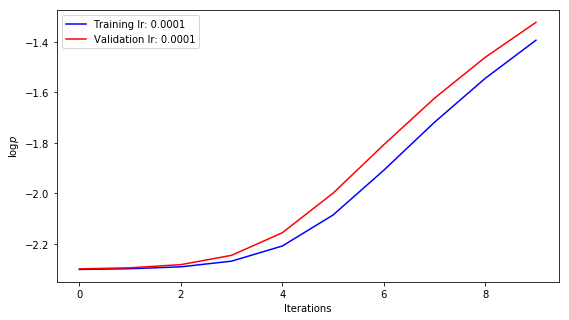

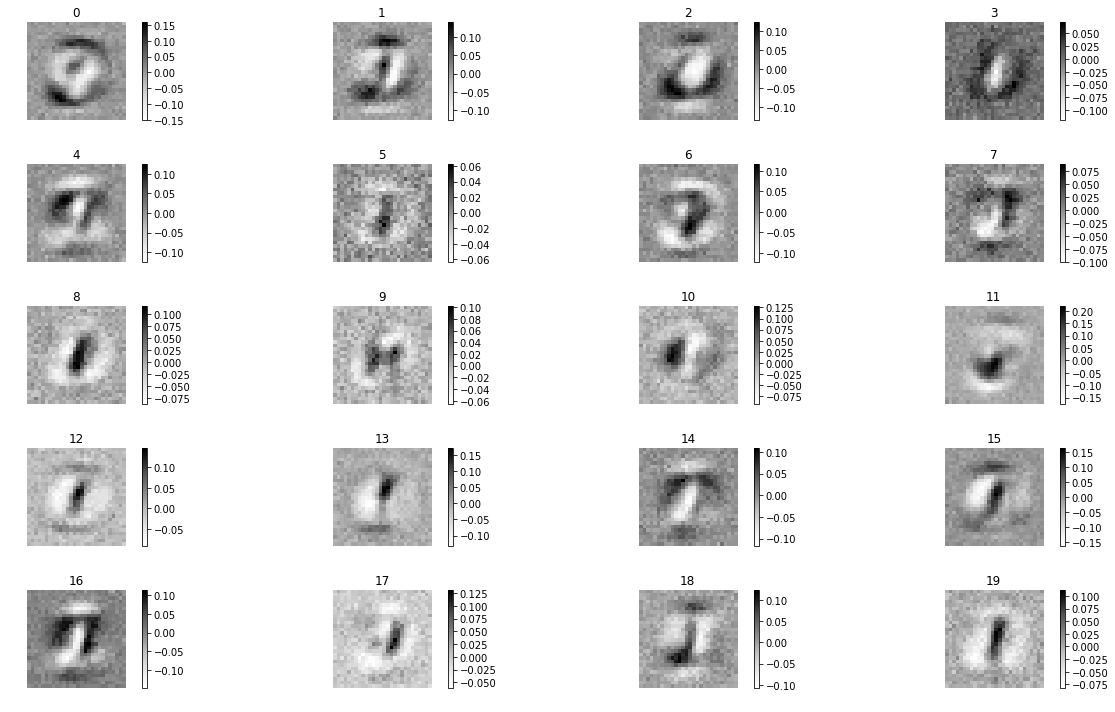

In [20]:
# Write training code here:
# Plot the conditional loglikelihoods for the train and validation dataset after every iteration.
# Plot the weights of the first layer.
np.random.seed(1243)
L = 20
sigma = 0.01
lrs = [1e-2, 1e-3, 1e-4]

results_lr = {}
for lr in lrs:
    w = np.random.randn(L, 10) * sigma
    b = np.zeros((10,))
    v = np.random.randn(28*28, L) * sigma
    a = np.zeros((L,))
    v, logp_train_data, logp_valid_data, v_best = test_sgd_mlp(x_train, t_train, x_valid, t_valid, 
                                                           w, b, v, a, epsilon=1e-2, lr=lr)
    results_lr[lr] = [v,logp_train_data,logp_valid_data, v_best]
    
plt.figure(figsize=(9,5))
plt.plot(np.arange(len(results_lr[1e-4][1])), results_lr[1e-4][1], color='blue', label='Training lr: 0.0001')
plt.plot(np.arange(len(results_lr[1e-4][2])), results_lr[1e-4][2], color='red', label='Validation lr: 0.0001')
plt.xlabel('Iterations')
plt.ylabel(r'$\log p$')
plt.legend()
plt.show()

plt.figure(figsize=(18,10))
plot_digits(data=results_lr[1e-4][0].T, num_cols=4,targets=np.arange(20))

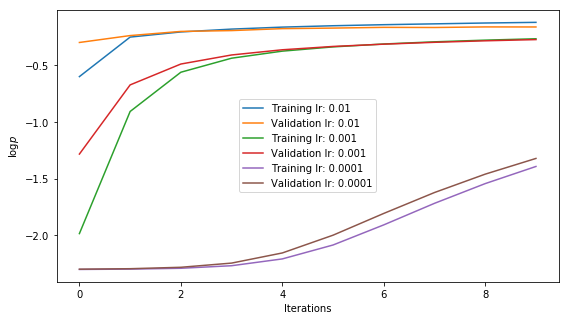

In [21]:
# plot the train and validation logp for all three learning rates in one figure
plt.figure(figsize=(9,5))
for lr in lrs:
    plt.plot(np.arange(len(results_lr[lr][1])), results_lr[lr][1], label='Training lr: {}'.format(lr))
    plt.plot(np.arange(len(results_lr[lr][2])), results_lr[lr][2], label='Validation lr: {}'.format(lr))

plt.xlabel('Iterations')
plt.ylabel(r'$\log p$')
plt.legend(loc=0)
plt.show()

### 2.3.1. Explain the learning curves (5 points)
In less than 80 words, explain the observed behaviour for the different learning rates.

As shown above, the slower the learning rate, the longer the log-likelihood converges. However, with large learning rates, the log-likelihood could result in imperfect convergence such that it oscillates around the optimum, whereas lower learning rates can ensure a steady but slow move to the optimum. A better strategy could be using a relatively large learning rate at the beginning and decrease it in the process, and the a good learning rate can be determined using validation set.

### 2.3.2. Explain the weights (5 points)
In less than 80 words, explain how and why the weights of the hidden layer of the MLP differ from the logistic regression model, and relate this to the stronger performance of the MLP.

Best model with learning rate: 0.01

Plotted weights of the first layer in epoch 0


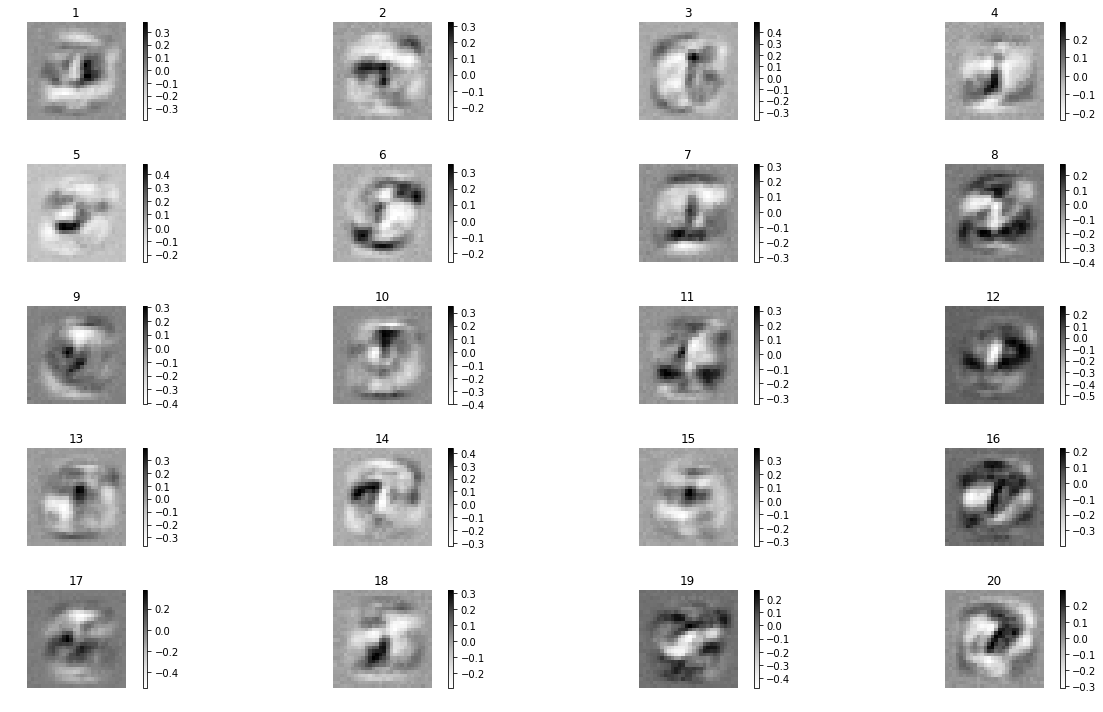

Plotted weights of the first layer in epoch 4


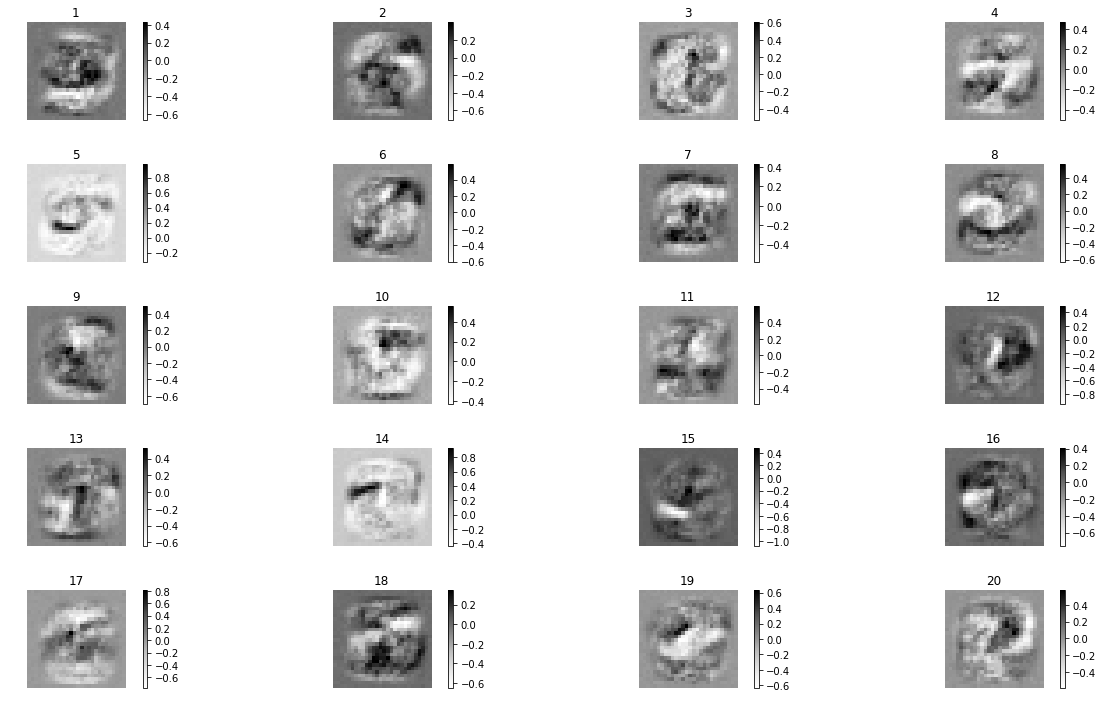

Plotted weights of the first layer in epoch 9


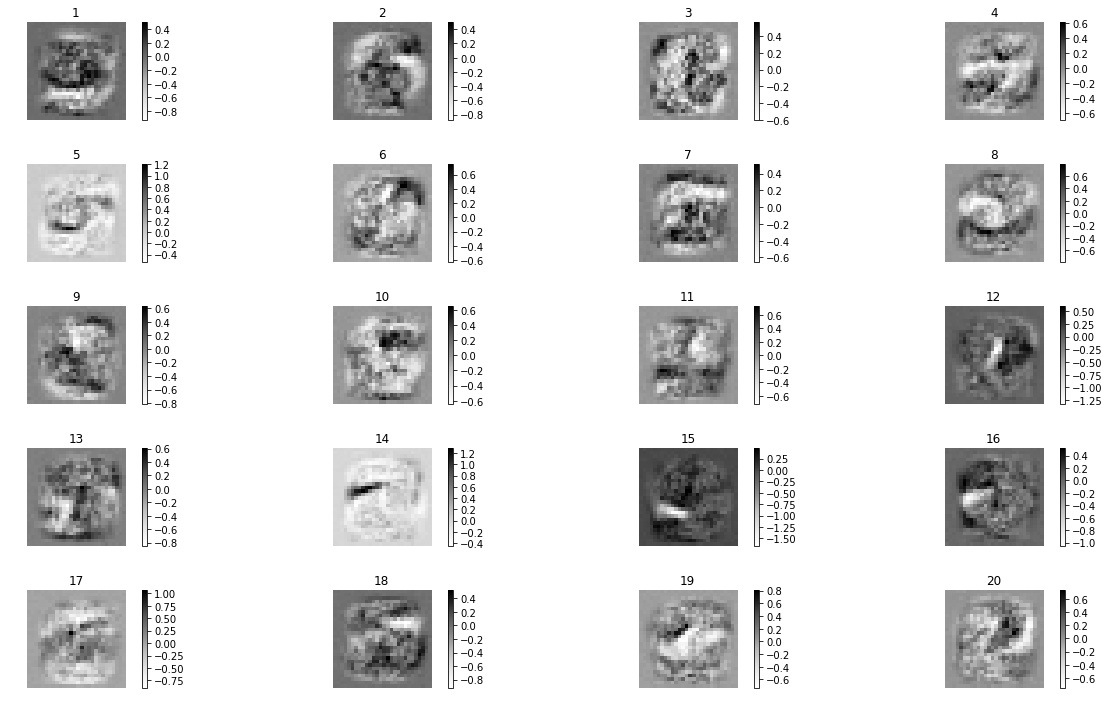

In [22]:
# Plot the weights of the first layer for the best model 

print("Best model with learning rate: 0.01\n")
j = 0
for i in [0,4,9]:
    print("Plotted weights of the first layer in epoch {}".format(i))
    plt.figure(figsize=(18,10))
    plot_digits(data=results_lr[1e-2][-1][j].T,num_cols=4,targets=np.arange(1,21))
    j+=1

Conceputally, the weights in MLP and in LR optimize in different levels. The former tries to find 20 features(edges, patterns) that distinguish the digits most while the latter optimize the likelihood in pixel level. Since sigmoid is non-linear, it "distorts" the feature space, which means weight of one feature may be influenced by features elsewhere. And the edge of MLP to LR is exactly the non-linear activation, because in dimensional space objects are not likely linearly separable.

### 2.3.2. Different activation functions (10 points)
In the task above we use a sigmoid as an activation function.
Two other popular choices for activation functions are tanh and the rectified linear unit (ReLU). The ReLU is defined as:

$$f(x) = \max(0.,x)$$

You already derived the derivative of the softmax function above. Here, write down the derivative for both the tanh and the ReLU function. Furthermore, for all three, plot the function and its derivative in a range $x\in[-3,3]$

Write down the derivative of ReLU and tanh w.r.t. their respective argument:

$$
\frac{\mathrm{d} \mathrm{ReLU}(x)}{\mathrm{d} x} = 
\begin{cases}
 1& \text{ if } x >0 \\ 
 0& \text{ if } x <0
\end{cases}
$$

$$
\frac{\mathrm{d} \tanh(x)}{\mathrm{d} x} = 1 - \tanh^{2}(x)
$$

Name two properties that you would like your activation function to have (one sentence each). Why are they important?

1. Its derivative should be simple for computational efficiency.

2. Its derivative should have a relative high value in a large range so that gradient vanishing may not likely happen and a relative fast convergence is guaranteed.


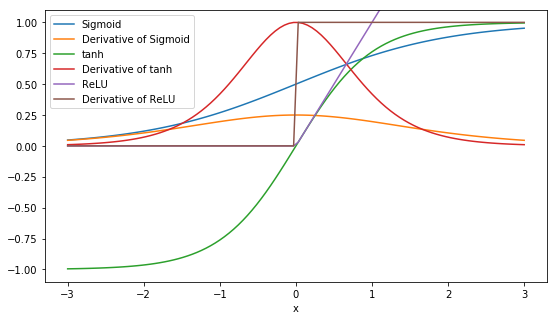

In [23]:
# plot the function and the derivative for the activations sigmoid, tanh and ReLU.
def derivative_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

def derivative_tanh(x):
    return 1 - np.tanh(x) ** 2

def ReLU(x):
    return np.maximum(0.0, x)

def derivative_ReLU(x):
    return np.heaviside(x, 0)
x = np.linspace(-3, 3, 100)
plt.figure(figsize=(9,5))
ax=plt.subplot(111)
plt.plot(x, sigmoid(x), label='Sigmoid')
plt.plot(x, derivative_sigmoid(x), label='Derivative of Sigmoid')
plt.plot(x, np.tanh(x), label='tanh')
plt.plot(x, derivative_tanh(x), label='Derivative of tanh')
plt.plot(x, ReLU(x), label='ReLU')
plt.plot(x, derivative_ReLU(x), label='Derivative of ReLU')
plt.xlabel('x')
plt.ylim(-1 * 1.1, 1 * 1.1)
plt.legend()
plt.show()


Now that you plotted the activations and derivatives, which activation do you think is the best? Why would you choose this activation function? For your answer consider what you named as essential properties for an activation function above. Keep your answer short at no more then 3 sentences.

From the plot above I would say ReLU is the best activeation function since
1. Its gradient is extremely easy to compute.
2. Its gradients is actually really stable, and over a very large range(postive), backpropagation should work really great and hence faster convergence, while negative case might be mitigated by positive initialization.

In [24]:
print('Notebook ran in {:2.3} minutes.'.format((time.time()-start)/60))

Notebook ran in 6.08 minutes.
